In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import numpy as np
import matplotlib.pyplot as plt

import time

In [2]:
# torch.manual_seed(42)

In [2]:
# device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(f'device: {device}')

device: cpu


In [3]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')

        self.layers = layers
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        self.H1 = self.linears[0]

        
    'forward pass'
    def forward(self,x,t):              
        
        # for i in range(len(self.layers)-2):
        #     z = self.linears[i](a)
        #     a = self.activation(z)

        a = torch.cat([x,t], dim = 1)    #(N,2)

        for i in range(len(self.layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)


            
        b = self.linears[-1](a) 
         
        return b
    
    # def forward_direct(self, x):
        
    #     z = x.float()
    #     H = self.linears[0].weight

    #     for i in range(len(self.layers)-2):
    #         L = self.linears[i](z)
    #         z = self.activation(L)
    #         G = (1-torch.square(z))*H.t() #\sigma'(L)*H
    #         H = torch.matmul(self.linears[i+1].weight,G.t())

    #     z = self.linears[-1](z)
         
    #     return z,H

In [4]:
# layers = np.array([2,50,50,50,50,50,1])
layers = np.array([2,20,20,20,20,20,1])
# PINN = Sequentialmodel(layers).to(device)

In [28]:
# Resetting to ensure the reported peak truly reflects the training loop, rather than including earlier setup.

# if device.type == 'cuda':
#     torch.cuda.reset_peak_memory_stats(device)

In [5]:
# Create the training data

import math

T=2*math.pi

x = torch.linspace(-1,1,100000).view(-1,1)
t = torch.linspace(0,1,100000).view(-1,1) * T


x_train = x.requires_grad_(True)      
t_train = t.requires_grad_(True)     

# x_train = x_train.reshape(-1,1).requires_grad_(True)     
# t_train = t_train.reshape(-1,1).requires_grad_(True)    



In [6]:
# Create boundary points

def generate_boundary_points(N = 2000):
    x_l = -torch.ones(N,1) ; x_r = torch.ones(N,1); t_lr = torch.linspace(0,1,N) * T

    x_l = x_l.view(-1,1)
    x_r = x_r.view(-1,1)
    t_lr = t_lr.view(-1,1)
   

  

    # x_0 = x_0.to(device)
    # x_1 = x_1.to(device)
    # ylr = ylr.to(device)


    return x_l, x_r, t_lr

In [7]:
def boundary_condition():

    x_l, x_r, t_lr = generate_boundary_points(N = 2000)

    u_left = PINN(x_l, t_lr)
    u_right = PINN(x_r, t_lr)


    res_left = u_left - (-torch.cos(t_lr))
    res_right = u_right - torch.cos(t_lr)

    return res_left, res_right




In [8]:
def generate_initial_points(N = 1000):
    x_i = torch.linspace(-1, 1,N).view(-1,1)
    t_i = torch.zeros(N,1).view(-1,1).requires_grad_(True)
    return x_i, t_i

In [9]:

def initial_condition():

  x_i, t_i = generate_initial_points(N = 1000)
  
  u_ic = PINN(x_i, t_i)

  res_ic_1 = u_ic - x_i

  u_t = torch.autograd.grad(u_ic, t_i, torch.ones_like(u_ic), create_graph=True)[0]
  res_ic_2 = u_t - torch.zeros_like(u_t)

#   res_ic = res_ic_1 + res_ic_2

  return res_ic_1, res_ic_2

In [10]:
def pde_residual(x,t):
    u = PINN(x,t)

    du_dx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    du_dt = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]

    du_dx_x = torch.autograd.grad(du_dx, x, torch.ones_like(du_dx), create_graph=True)[0]
    du_dt_t = torch.autograd.grad(du_dt, t, torch.ones_like(du_dt), create_graph=True)[0]

    res_pde = du_dt_t - du_dx_x + (u**2) + x*torch.cos(t)-(x**2) *torch.cos(t)**2

    return res_pde

In [11]:
def compute_losses():
   res_pde = pde_residual(x_train,t_train) 
   res_ic_1, res_ic_2 = initial_condition()
   res_left, res_right = boundary_condition()

   loss_pde = torch.mean(res_pde**2)
   loss_ic = torch.mean(res_ic_1**2) + torch.mean(res_ic_2**2)
   loss_bc = torch.mean(res_left**2) + torch.mean(res_right**2)

   total_loss = loss_pde + loss_ic + loss_bc

   return total_loss

In [59]:
# optimizer = torch.optim.Adam(PINN.parameters(), lr=0.01)

In [19]:
# No. of epochs


# start_time = time.time()

# num_epochs = 10000



# for epoch in range(num_epochs):
#     optimizer.zero_grad()

#     total_loss = compute_losses()

    
#     total_loss.backward()

#     optimizer.step()

#     if (epoch) % 200 == 0:
#      print(f'Epoch {epoch}, Loss: {total_loss.item()}')


# end_time = time.time()

# print(f'Total Training Time: {(end_time - start_time): .4f}seconds')


    








In [12]:
torch.manual_seed(42)
# PINN = Sequentialmodel(layers).to(device)
PINN = Sequentialmodel(layers)

In [38]:
# if device.type == 'cuda':
#     torch.cuda.reset_peak_memory_stats(device)

In [22]:
# optimizer = torch.optim.Adam(PINN.parameters(), lr=0.01)

In [23]:
# # Threshold loss as the stopping criteria

# max_epochs = 15000
# threshold = 0.002



# start_time = time.time()

# ep = 0
# while ep < max_epochs:
#     optimizer.zero_grad()

#     total_loss = compute_losses()

    
#     total_loss.backward()

#     optimizer.step()


#     if total_loss.item() < threshold:
#         print(f"Reached threshold loss {threshold} at epoch {ep}")
#         break

#     if (ep) % 200 == 0:
#      print(f'Epoch {ep}, Loss: {total_loss.item()}')

#     ep += 1


# print(f"Training stopped at epoch {ep}, total time {time.time() - start_time:.2f} s")





In [ ]:
# # Using LBFGS

# optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.05,max_iter=20,history_size=50,tolerance_grad=1e-9,tolerance_change=1e-9,line_search_fn='strong_wolfe')

# max_outer_steps = 15000
# threshold = 0.002

# start_time = time.time()
# ep = 0


# def closure():

#     optimizer.zero_grad()
#     total_loss = compute_losses()
#     total_loss.backward()

#     return total_loss

# while ep < max_outer_steps:

#     total_loss = optimizer.step(closure)

#     if total_loss.item() < threshold:
#         print(f"Reached threshold loss {threshold} at outer step {ep}")
#         break

#     if ep % 200 == 0:
#         print(f'Outer {ep}, Loss: {total_loss.item()}')

#     ep += 1

# print(f"Training stopped at outer step {ep}, total time {time.time() - start_time:.2f} s")
    

Outer 0, Loss: 1.8242416381835938
Reached threshold loss 0.002 at outer step 16
Training stopped at outer step 16, total time 19.48 s


In [13]:
# Saving Checkpoints

optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.05,max_iter=20,history_size=50,tolerance_grad=1e-9,tolerance_change=1e-9,line_search_fn='strong_wolfe')

max_outer_steps = 15000
threshold = 0.002

outer_hist = []
best_loss = float('inf')
best_path = "kg_autograd_best.pt"
last_path = "kg_autograd_last.pt"

start_time = time.time()
ep = 0

def closure():

    optimizer.zero_grad()
    total_loss = compute_losses()
    total_loss.backward()

    return total_loss

while ep < max_outer_steps:
    total_loss = optimizer.step(closure)          # LBFGS returns loss after step
    loss_val = float(total_loss.detach())
    outer_hist.append(loss_val)

    if loss_val < best_loss:
        best_loss = loss_val
        torch.save({"model_state": PINN.state_dict(),"optimizer_state": optimizer.state_dict(),"layers": layers.tolist(),"outer_hist": outer_hist,"seed": 42,"problem": "KG-1D+t (your setup)"},best_path)

    if loss_val < threshold:
        print(f"Reached threshold loss {threshold} at outer step {ep}")
        break

    # if ep % 200 == 0:
    #     print(f'Outer {ep}, Loss: {loss_val}')
    # ep += 1

    print(f'Outer {ep}, Loss: {loss_val:.6e}')
    ep += 1

print(f"Training stopped at outer step {ep}, total time {time.time() - start_time:.2f} s")

torch.save({"model_state": PINN.state_dict(),"optimizer_state": optimizer.state_dict(),"layers": layers.tolist(),"outer_hist": outer_hist,"seed": 42,"problem": "KG-1D+t (your setup)"},last_path)



print(f"Saved best to {best_path} and last to {last_path}")


Outer 0, Loss: 1.814326e+00
Outer 1, Loss: 9.387269e-01
Outer 2, Loss: 5.743133e-01
Outer 3, Loss: 4.208981e-01
Outer 4, Loss: 2.136263e-01
Outer 5, Loss: 1.072765e-01
Outer 6, Loss: 5.793597e-02
Outer 7, Loss: 3.136491e-02
Outer 8, Loss: 1.594926e-02
Outer 9, Loss: 5.515370e-03
Outer 10, Loss: 3.973020e-03
Outer 11, Loss: 3.017147e-03
Outer 12, Loss: 2.563136e-03
Outer 13, Loss: 2.420348e-03
Outer 14, Loss: 2.290653e-03
Reached threshold loss 0.002 at outer step 15
Training stopped at outer step 15, total time 60.31 s
Saved best to kg_autograd_best.pt and last to kg_autograd_last.pt


In [54]:
# # Memory usage after training

# if device.type == 'cuda':
#     peak_mem = torch.cuda.max_memory_allocated(device)
#     print(f'Peak GPU Memory Usage: {peak_mem / 1e6: .2f} MB')

In [14]:
def u_closed_form(x, t):
    sol = x*torch.cos(t)
    return sol

In [15]:
import math

T=2*math.pi

x_test = torch.linspace(-1,1,600).view(-1,1)
t_test = torch.rand(600,1) * T

u_true = u_closed_form(x_test, t_test)
u_pred = PINN(x_test,t_test)

mse = torch.mean((u_pred - u_true)**2).item()
print(f"MSE vs closed-form: {mse:.3e}")



MSE vs closed-form: 1.013e-02


In [20]:
def compare(PINN):
    PINN.eval()


    x_test = torch.linspace(-1,1,500).view(-1,1)
    t_test = torch.linspace(0,1,500).view(-1,1) * T

    x_test,t_test = torch.meshgrid(x_test.squeeze(),t_test.squeeze(), indexing = 'ij')

    x_test = x_test.reshape(-1,1)     
    t_test = t_test.reshape(-1,1) 



    # if torch.is_tensor(x_test) != True:  
    #     x_test = torch.from_numpy(x_test)
    # if torch.is_tensor(y_test) != True:  
    #     y_test = torch.from_numpy(y_test)   


    # #convert to float
    # x = x_test.float()
    # y = y_test.float()    
    

    
   

# x_train = x_train.reshape(-1,1).to(device)     
# y_train = y_train.reshape(-1,1).to(device) 


  


    u_true = u_closed_form(x_test, t_test).reshape(500,500)


    u_pred = PINN(x_test,t_test).reshape(500,500)

    u_pred_np = u_pred.detach().cpu()

    mse = torch.mean((u_pred_np - u_true)**2).item()
    print(f"MSE vs closed-form (grid): {mse:.3e}")


    fig, axs = plt.subplots(1, 2, figsize=(12, 3.6), constrained_layout=True)
    im0 = axs[0].imshow(u_true.cpu(), origin='lower', cmap = "jet", extent=[0,T,-1,1])
    axs[0].set_title("Closed-form")
    axs[0].set_xlabel('t'); axs[0].set_ylabel('x'); fig.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(u_pred_np.cpu(), origin='lower', cmap = "jet", extent=[0,T,-1,1])
    axs[1].set_title("PINN Prediction")
    axs[1].set_xlabel('t'); axs[1].set_ylabel('x'); fig.colorbar(im1, ax=axs[1])



    # Saving the plot

    # plt.savefig('Closed-form_solution_vs_PINN_prediction.svg',format = 'svg',bbox_inches = 'tight')

    for ext in ["png", "pdf", "svg","eps"]:
      plt.savefig(f"Klein_Gordon_autograd.{ext}", bbox_inches='tight', dpi=300)

  

    plt.show()


[BEST CKPT] MSE vs closed-form: 1.152e-02
MSE vs closed-form (grid): 1.096e-02


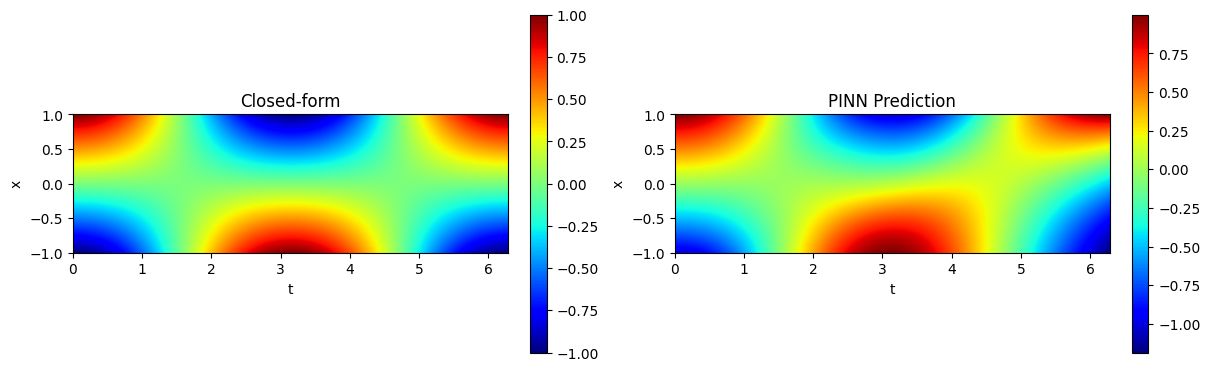

In [21]:
def load_checkpoint(path, device="cpu"):
    ck = torch.load(path, map_location=device)
    net = Sequentialmodel(np.array(ck["layers"]))
    net.load_state_dict(ck["model_state"])
    net.to(device).eval()
    return net, ck

model_best, ck = load_checkpoint("kg_autograd_best.pt", device="cpu")

with torch.no_grad():
    x_test = torch.linspace(-1,1,600).view(-1,1)
    t_test = torch.rand(600,1) * T
    u_true = u_closed_form(x_test, t_test)
    u_pred = model_best(x_test, t_test)
    mse = torch.mean((u_pred - u_true)**2).item()
print(f"[BEST CKPT] MSE vs closed-form: {mse:.3e}")


compare(model_best)

MSE vs closed-form (grid): 1.096e-02


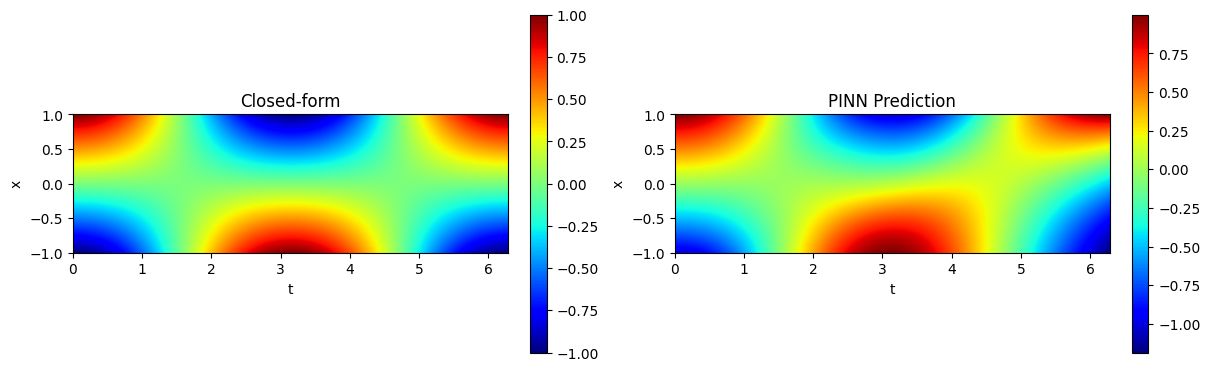

In [22]:
compare(PINN)

In [23]:
import os

def load_ckpt(path, device="cpu"):
    ck = torch.load(path, map_location=device)
    return ck

def plot_convergence(paths, labels=None, ylim=None):
    """
    paths: list[str] of .pt checkpoint files (each must contain 'outer_hist')
    labels: list[str] (optional), same length as paths
    """
    if labels is None: labels = [os.path.basename(p) for p in paths]
    plt.figure(figsize=(6.0, 4.0))
    for p, lab in zip(paths, labels):
        ck = load_ckpt(p)
        hist = ck["outer_hist"]
        plt.plot(hist, label=lab, linewidth=1.8)
    plt.xlabel("LBFGS outer step")
    plt.ylabel("Loss")
    if ylim: plt.ylim(*ylim)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.title("Convergence")
    plt.tight_layout()
    plt.show()

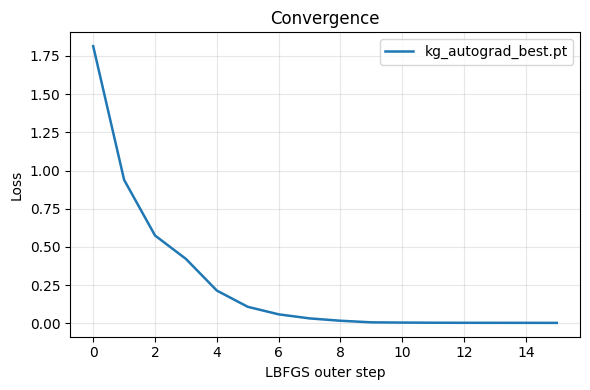

In [24]:
plot_convergence(["kg_autograd_best.pt"])

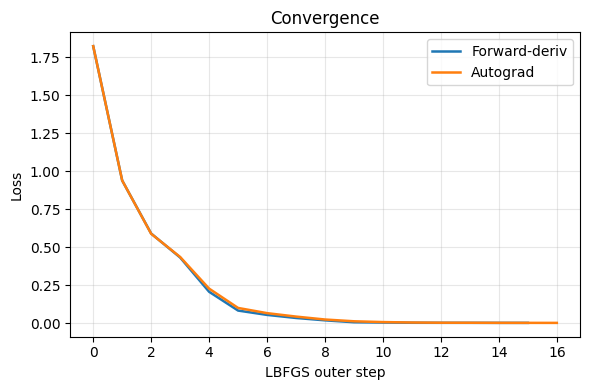

Functional MSE (Forward vs Autograd): 1.706e-03 | Relative L2: 9.596e-02
Forward vs closed form: (0.01067329104989767, 0.2507163882255554)
Autograd vs closed form: (0.01207413524389267, 0.26666224002838135)


In [ ]:
# ck_forward  = "kg_forward_best.pt"   # forward-derivatives run
# ck_autograd = "kg_autograd_best.pt"  # autograd run

# def load_model_from_ckpt(path, device="cpu"):
#     ck = torch.load(path, map_location=device)
#     net = Sequentialmodel(np.array(ck["layers"]))
#     net.load_state_dict(ck["model_state"])
#     net.to(device).eval()
#     return net, ck

# mF, ckF = load_model_from_ckpt(ck_forward,  device)
# mA, ckA = load_model_from_ckpt(ck_autograd, device)





# def plot_convergence(cks, labels):
#     plt.figure(figsize=(6,4))
#     for ck, lab in zip(cks, labels):
#         hist = np.array(ck["outer_hist"], dtype=float)
#         plt.plot(hist, label=lab, lw=1.8)
#     plt.xlabel("LBFGS outer step"); plt.ylabel("Loss"); plt.grid(alpha=.3)
#     plt.legend(); plt.title("Convergence"); plt.tight_layout(); plt.show()

# plot_convergence([ckF, ckA], ["Forward-deriv", "Autograd"])






# def functional_mse_kg(modelA, modelB, nx=161, nt=161, device="cpu"):
#     xs = torch.linspace(-1, 1, nx, device=device).view(-1,1)
#     ts = torch.linspace( 0,  T, nt, device=device).view(-1,1)
#     X, TT = torch.meshgrid(xs.squeeze(), ts.squeeze(), indexing="ij")
#     xg, tg = X.reshape(-1,1), TT.reshape(-1,1)
#     uA = modelA(xg, tg); uB = modelB(xg, tg)
#     mse  = torch.mean((uA - uB)**2).item()
#     relL2 = torch.sqrt(torch.mean((uA - uB)**2)/(torch.mean(uA**2)+1e-12)).item()
#     return mse, relL2

# mse, rel = functional_mse_kg(mF, mA, device=device)
# print(f"Functional MSE (Forward vs Autograd): {mse:.3e} | Relative L2: {rel:.3e}")




# def mse_vs_closed_form(model, nx=161, nt=161, device="cpu"):
#     xs = torch.linspace(-1, 1, nx, device=device).view(-1,1)
#     ts = torch.linspace( 0,  T, nt, device=device).view(-1,1)
#     X, TT = torch.meshgrid(xs.squeeze(), ts.squeeze(), indexing="ij")
#     xg, tg = X.reshape(-1,1), TT.reshape(-1,1)
#     u_true = xg * torch.cos(tg)
#     u_pred = model(xg, tg)
#     mse  = torch.mean((u_pred - u_true)**2).item()
#     relL2 = torch.sqrt(torch.mean((u_pred - u_true)**2)/(torch.mean(u_true**2)+1e-12)).item()
#     return mse, relL2

# print("Forward vs closed form:",  mse_vs_closed_form(mF, device=device))
# print("Autograd vs closed form:", mse_vs_closed_form(mA, device=device))